In [171]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("cleaned_h1b.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,CASE_STATUS,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_POSTAL_CODE,EMPLOYER_COUNTRY,AGENT_REPRESENTING_EMPLOYER,JOB_TITLE,SOC_CODE,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,PW_WAGE_LEVEL,PW_SOURCE,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,WORKSITE_STATE,WORKSITE_POSTAL_CODE,DECISION_DURATION,EMPLOYMENT_DURATION
0,CERTIFIED-WITHDRAWN,H-1B,DISCOVER PRODUCTS INC.,IL,60015,UNITED STATES OF AMERICA,Y,ASSOCIATE DATA INTEGRATION,15-1121,522210,1,1,0,0,0,0,0,Y,59197.0,Year,Level I,OES,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,X,Y,IL,60015,220,1095
1,CERTIFIED-WITHDRAWN,H-1B,DFS SERVICES LLC,IL,60015,UNITED STATES OF AMERICA,Y,SENIOR ASSOCIATE,15-2031,522210,1,1,0,0,0,0,0,Y,49800.0,Year,Level V,Other,2015.0,TOWERS WATSON DATA SERVICES 2015 CSR PROFESSIO...,53000.0,57200.0,Year,N,N,X,Y,IL,60015,211,1095
2,CERTIFIED-WITHDRAWN,H-1B,EASTBANC TECHNOLOGIES LLC,DC,20007,UNITED STATES OF AMERICA,Y,.NET SOFTWARE PROGRAMMER,15-1131,541511,2,2,0,0,0,0,0,Y,76502.0,Year,Level II,OES,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,Y,X,DC,20007,205,1095
3,WITHDRAWN,H-1B,INFO SERVICES LLC,MI,48152,UNITED STATES OF AMERICA,N,PROJECT MANAGER,15-1199,541511,1,1,0,0,0,0,0,Y,90376.0,Year,Level III,OES,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,Y,X,NJ,07302,3,1094
4,CERTIFIED-WITHDRAWN,H-1B,BB&T CORPORATION,NC,27893,UNITED STATES OF AMERICA,Y,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,13-2041,522110,1,0,0,0,0,1,0,Y,116605.0,Year,Level III,OES,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,X,Y,NY,10036,588,1096


In [6]:
# Dropping columns passing redundant information.
df.drop(['WORKSITE_POSTAL_CODE','EMPLOYER_POSTAL_CODE'],axis=1,inplace=True)

In [7]:
numerical = df.select_dtypes(include=np.number)
categorical = df.select_dtypes(exclude=np.number)

In [8]:
df.head()

,CASE_STATUS,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,AGENT_REPRESENTING_EMPLOYER,JOB_TITLE,SOC_CODE,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,PW_WAGE_LEVEL,PW_SOURCE,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,WORKSITE_STATE,DECISION_DURATION,EMPLOYMENT_DURATION
0,CERTIFIED-WITHDRAWN,H-1B,DISCOVER PRODUCTS INC.,IL,UNITED STATES OF AMERICA,Y,ASSOCIATE DATA INTEGRATION,15-1121,522210,1,1,0,0,0,0,0,Y,59197.0,Year,Level I,OES,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,X,Y,IL,220,1095
1,CERTIFIED-WITHDRAWN,H-1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,Y,SENIOR ASSOCIATE,15-2031,522210,1,1,0,0,0,0,0,Y,49800.0,Year,Level V,Other,2015.0,TOWERS WATSON DATA SERVICES 2015 CSR PROFESSIO...,53000.0,57200.0,Year,N,N,X,Y,IL,211,1095
2,CERTIFIED-WITHDRAWN,H-1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,Y,.NET SOFTWARE PROGRAMMER,15-1131,541511,2,2,0,0,0,0,0,Y,76502.0,Year,Level II,OES,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,Y,X,DC,205,1095
3,WITHDRAWN,H-1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,N,PROJECT MANAGER,15-1199,541511,1,1,0,0,0,0,0,Y,90376.0,Year,Level III,OES,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,Y,X,NJ,3,1094
4,CERTIFIED-WITHDRAWN,H-1B,BB&T CORPORATION,NC,UNITED STATES OF AMERICA,Y,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,13-2041,522110,1,0,0,0,0,1,0,Y,116605.0,Year,Level III,OES,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,X,Y,NY,588,1096


In [14]:
for col in list(categorical.columns):
    try:
        categorical[col] = LabelEncoder().fit_transform(categorical[col])
    except:
        print('Issue in label encoding.')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Issue in label encoding.


In [11]:
df.columns

Index(['CASE_STATUS', 'VISA_CLASS', 'EMPLOYER_NAME', 'EMPLOYER_STATE',
       'EMPLOYER_COUNTRY', 'AGENT_REPRESENTING_EMPLOYER', 'JOB_TITLE',
       'SOC_CODE', 'NAICS_CODE', 'TOTAL_WORKERS', 'NEW_EMPLOYMENT',
       'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
       'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'PW_UNIT_OF_PAY',
       'PW_WAGE_LEVEL', 'PW_SOURCE', 'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER',
       'WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO', 'WAGE_UNIT_OF_PAY',
       'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'SUPPORT_H1B', 'LABOR_CON_AGREE',
       'WORKSITE_STATE', 'DECISION_DURATION', 'EMPLOYMENT_DURATION'],
      dtype='object')

In [13]:
categorical.dtypes

CASE_STATUS                     int64
VISA_CLASS                      int64
EMPLOYER_NAME                   int64
EMPLOYER_STATE                  int64
EMPLOYER_COUNTRY                int64
AGENT_REPRESENTING_EMPLOYER     int64
JOB_TITLE                       int64
SOC_CODE                        int64
NAICS_CODE                     object
FULL_TIME_POSITION             object
PW_UNIT_OF_PAY                 object
PW_WAGE_LEVEL                  object
PW_SOURCE                      object
PW_SOURCE_OTHER                object
WAGE_UNIT_OF_PAY               object
H1B_DEPENDENT                  object
WILLFUL_VIOLATOR               object
SUPPORT_H1B                    object
LABOR_CON_AGREE                object
WORKSITE_STATE                 object
dtype: object

In [17]:
categorical.CASE_STATUS.value_counts(0)

0    545672
1     49701
3     20759
2      8412
Name: CASE_STATUS, dtype: int64

In [30]:
for col in list(categorical.columns):
    try:
        categorical[col] = categorical[col].astype(int)
    except:
        print('Error!')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Error!


In [31]:
categorical.dtypes

CASE_STATUS                     int32
VISA_CLASS                      int32
EMPLOYER_NAME                   int32
EMPLOYER_STATE                  int32
EMPLOYER_COUNTRY                int32
AGENT_REPRESENTING_EMPLOYER     int32
JOB_TITLE                       int32
SOC_CODE                        int32
NAICS_CODE                     object
FULL_TIME_POSITION              int32
PW_UNIT_OF_PAY                  int32
PW_WAGE_LEVEL                   int32
PW_SOURCE                       int32
PW_SOURCE_OTHER                 int32
WAGE_UNIT_OF_PAY                int32
H1B_DEPENDENT                   int32
WILLFUL_VIOLATOR                int32
SUPPORT_H1B                     int32
LABOR_CON_AGREE                 int32
WORKSITE_STATE                  int32
dtype: object

In [34]:
categorical.drop('NAICS_CODE',1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [35]:
# Merging Dataframes.
encoded_dataframe = pd.concat([numerical,categorical],axis=1)

In [148]:
x = encoded_dataframe.drop('CASE_STATUS',1)
y = encoded_dataframe.CASE_STATUS
random_under_sampler = RandomUnderSampler(random_state=0)
x_us,y_us = random_under_sampler.fit_resample(x,y)
y_us = pd.Series(y_us)
x_us = pd.DataFrame(x_us,columns=x.columns)
x_train,x_test,y_train,y_test = train_test_split(x_us,y_us,test_size=0.3,random_state=0)

In [91]:
y_us.value_counts()

3    8412
2    8412
1    8412
0    8412
dtype: int64

In [99]:
param_rfc = {
    'n_estimators' : [50,100,200],
    'min_samples_split' : [2,3,5],
    'max_depth' : [2,3,8]
}

param_xgb = {
    'n_estimators' : [50,100,200],
    'max_depth' : [2,3,8],
    'learning_rate' : [0.01,0.02,0.03,0.1]
}

param_lgb = {
    'n_estimators' : [50,100,200],
    'max_depth' : [2,3,8],
    'learning_rate' : [0.01,0.02,0.03,0.1],
    'min_split_gain' : [0.0,0.01,0.1,0.3,0.5]
}

In [142]:
# Random Forest
model_rfc = RandomForestClassifier(class_weight='balanced',n_estimators=100,max_depth=20)
y_pred = model_rfc.fit(x_train,y_train).predict(x_test)
print('Train Accuracy Score: {}'.format(model_rfc.score(x_train,y_train)))
print('Test Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Train Accuracy Score: 0.9747378253301066
Test Accuracy Score: 0.8204061416542843


ValueError: multiclass format is not supported

In [140]:
model_rfc

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [121]:
# AdaBoost
model_adaboost = AdaBoostClassifier(learning_rate=0.1)
ada_bagging_model = BaggingClassifier(base_estimator=model_adaboost)
y_pred = ada_bagging_model.fit(x_train,y_train).predict(x_test)
y_pred_train = ada_bagging_model.fit(x_train,y_train).predict(x_train)
print('Train Accuracy Score: {}'.format(ada_bagging_model.score(x_train,y_train)))
print('Test Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Train Accuracy Score: 0.6401307689041735
Test Accuracy Score: 0.6300148588410104
              precision    recall  f1-score   support

           0       0.64      0.94      0.76      2515
           1       0.83      0.97      0.90      2489
           2       0.45      0.62      0.52      2536
           3       0.00      0.00      0.00      2555

   micro avg       0.63      0.63      0.63     10095
   macro avg       0.48      0.63      0.55     10095
weighted avg       0.48      0.63      0.54     10095

[[2370    5  140    0]
 [  70 2418    1    0]
 [ 955    9 1572    0]
 [ 297  478 1780    0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [123]:
# XGBoost
model_xgboost = XGBClassifier(learning_rate=0.1)
y_pred = model_xgboost.fit(x_train,y_train).predict(x_test)
print('Train Accuracy Score: {}'.format(model_xgboost.score(x_train,y_train)))
print('Test Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Train Accuracy Score: 0.8086867914915298
Test Accuracy Score: 0.79247152055473
              precision    recall  f1-score   support

           0       0.72      0.91      0.81      2515
           1       0.87      0.97      0.92      2489
           2       0.72      0.70      0.71      2536
           3       0.89      0.60      0.72      2555

   micro avg       0.79      0.79      0.79     10095
   macro avg       0.80      0.79      0.79     10095
weighted avg       0.80      0.79      0.79     10095

[[2285   11  218    1]
 [  48 2425    3   13]
 [ 583   17 1764  172]
 [ 238  332  459 1526]]


In [170]:
# LightGBM
model_lgb = LGBMClassifier(class_weight='balanced',learning_rate=0.1)
y_pred = model_lgb.fit(x_train,y_train).predict(x_test)
y_pred_train = model_lgb.fit(x_train,y_train).predict(x_train)
print('Train Accuracy Score: {}'.format(accuracy_score(y_train,y_pred_train)))
print('Test Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Train Accuracy Score: 0.8736042117776929
Test Accuracy Score: 0.8240713224368499
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      2515
           1       0.90      0.97      0.93      2489
           2       0.76      0.75      0.76      2536
           3       0.89      0.67      0.77      2555

   micro avg       0.82      0.82      0.82     10095
   macro avg       0.83      0.83      0.82     10095
weighted avg       0.83      0.82      0.82     10095

[[2291    9  212    3]
 [  38 2411   10   30]
 [ 444    9 1897  186]
 [ 227  246  362 1720]]


NameError: name 'sns' is not defined

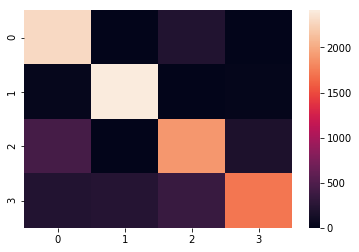

In [172]:
sns.heatmap(confusion_matrix(y_test,y_pred),)

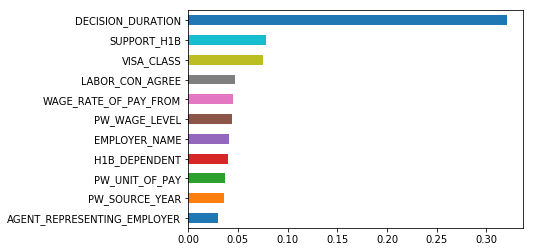

In [130]:
# XGBoost Feature Importance
feature_importance = pd.Series(model_xgboost.feature_importances_,index=list(x_train.columns))
feature_importance = feature_importance[feature_importance>0.03].sort_values(ascending=True)
feature_importance.plot('barh')

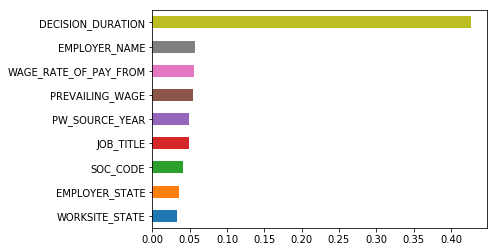

In [129]:
# Random Forest Feature Importance
feature_importance = pd.Series(model_rfc.feature_importances_,index=list(x_train.columns))
feature_importance = feature_importance[feature_importance>0.03].sort_values(ascending=True)
feature_importance.plot('barh')

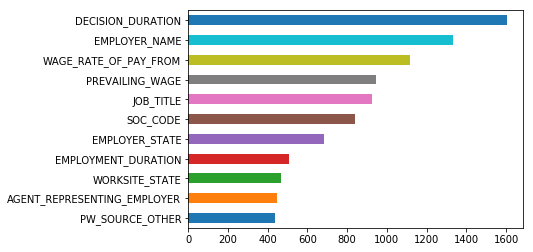

In [132]:
# LightGBM Feature Importance
feature_importance = pd.Series(model_lgb.feature_importances_,index=list(x_train.columns))
feature_importance = feature_importance[feature_importance>400].sort_values(ascending=True)
feature_importance.plot('barh')

In [133]:
# Stacking Classifier
classifiers = [model_rfc,model_xgboost,model_lgb]
meta_classifier = KNeighborsClassifier()
stacker_model = StackingClassifier(classifiers=classifiers,meta_classifier=meta_classifier)
y_pred = stacker_model.fit(x_train,y_train).predict(x_test)
print('Train Accuracy Score: {}'.format(stacker_model.score(x_train,y_train)))
print('Test Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print('Test Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Train Accuracy Score: 0.9896403855135227
Test Accuracy Score: 0.8013868251609708
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      2515
           1       0.91      0.95      0.93      2489
           2       0.73      0.70      0.71      2536
           3       0.83      0.69      0.76      2555

   micro avg       0.80      0.80      0.80     10095
   macro avg       0.80      0.80      0.80     10095
weighted avg       0.80      0.80      0.80     10095

[[2171    7  305   32]
 [  39 2375    8   67]
 [ 486   16 1775  259]
 [ 222  205  359 1769]]


In [143]:
y.shape

(624544,)

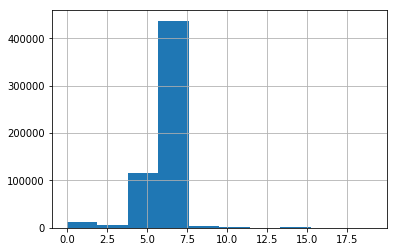

In [167]:
df[df.DECISION_DURATION<20].DECISION_DURATION.hist()

In [169]:
df.DECISION_DURATION.value_counts()

6       372384
4        98293
7        64678
5        16471
0         8109
1         4378
2         3003
8         2881
3         2267
10         450
106        431
14         424
9          408
15         372
21         354
13         323
11         318
16         316
12         304
20         264
18         255
26         241
19         238
22         235
17         231
27         226
112        209
34         199
35         188
23         186
         ...  
1705         1
1485         1
1316         1
1479         1
1486         1
1313         1
1118         1
1732         1
1330         1
2214         1
1337         1
1297         1
1645         1
1295         1
1258         1
1291         1
1339         1
1290         1
1136         1
1345         1
1284         1
1249         1
1283         1
1215         1
1863         1
1282         1
1760         1
1697         1
1281         1
1535         1
Name: DECISION_DURATION, Length: 1312, dtype: int64